# Practica Final de Modulo 7 - Introducción a Process Mining

**Enunciado**

Una empresa de 15 trabajadores con sus sistemas albergados en la nube (ERP, CRM, control de *stock*…) quiere implantar una estrategia de analítica también en la nube (Azure).

Para ello desarrolla una serie de funciones *serverless* que se ejecutan periódicamente a las 2:00 am, y donde se copia la información de las bases de datos a ficheros CSV en un almacenamiento distribuido y se puede desde ahí leerlo con cualquier herramienta (*notebook*, diseñadores, AutoML…) e incluso enviar datos a aplicaciones de BI como Celonis y PowerBI.

En cuanto a sus necesidades de IA, necesitan un sistema predictivo para las ventas futuras, para así poder determinar el *stock* que necesitarán, otro que les prediga los clientes con una alta probabilidad de contratar un producto vía telefónica y, por último, varios algoritmos que se entrenan y se ejecutan de forma puntual para determinar determinados aspectos del negocio (como qué clientes tienen más propensión a aceptar una determinada oferta o un estudio especial de algún aspecto del negocio).

Considérese que el *dataset* que indica si un cliente va a contratar o no un producto vía telefónica es *bank marketing*, ubicado en https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing, y en concreto, “bank-full.csv”.

**Se pide**

Contestar justificando todas y cada uno de los apartados y las decisiones tomadas:

**1 -** Describir la forma de productivizar cada modelo.

¿Qué tipo de herramienta se debería elegir para desarrollar cada modelo y por qué se ha elegido?


¿Cuál sería la forma de acceder a los modelos por parte de los usuarios?

¿Cada cuánto tendrían que reentrenarse?

**2 -** Describir el flujo de trabajo MLOps de los modelos. ¿Sería necesario en todos los modelos?

**3 -** ¿Qué cambios habría que hacer en los apartados anteriores si la empresa, en vez de 15 trabajadores, tuviese 10000?

**4 -** Productivizar el modelo de *bank marketing*. Hay dos opciones para elegir: mediante el diseñador de Azure o bien de forma manual en su propia máquina (serializando los modelos/transformaciones con Pickle).

1. Si el objetivo del modelo es lograr predecir previo a que se realice la llamada qué personas tienen una alta probabilidad de contratar, ¿se podría decir si hay alguna variable que no sea posible incluir en el modelo en producción?, ¿Cuáles son?
2. Probar varios modelos e ingeniería de características y dar con el modelo que mejor métrica presente.

Una vez elegido el mejor modelo, crear una llamada API para consultar el modelo. En caso de haber elegido hacer un modelo de forma manual, se tendrá que generar el código para responder a la llamada *GET* o *POST* con los nuevos datos. En caso de haber elegido hacerlo con Azure, se deberá crear el *endpoint* (hay que recordar que, posiblemente, al usar una cuenta gratuita, no se pueda ejecutar debido a que necesitaría más CPU de las que está permitido usar; no obstante, se deberá plantear la canalización y adjuntar captura de pantalla de ella aunque dé error).

### Cargando Datasets para Entrenamiento de Modelos

In [185]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/IMF/M7_Introduccion_Process_Mining/Practicas/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
df_bank = pd.read_csv(f'{base_path}/Datasets/bank_marketing/bank/bank-full.csv', sep=';')

In [187]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [188]:
display(df_bank.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Creando un modelo para predicción de ventas futuras


In [189]:
# Convertir mes a número
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
             'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
df_bank['month_num'] = df_bank['month'].map(month_map)

# Crear fecha artificial (año ficticio)
df_bank['date'] = pd.to_datetime('2024-' + df_bank['month_num'].astype(str) + '-' + df_bank['day'].astype(str), errors='coerce')

# Agrupar ventas por día
df_daily_sales = df_bank.groupby('date')['y'].apply(lambda x: (x == 'yes').sum()).reset_index()
df_daily_sales.rename(columns={'y':'ventas'}, inplace=True)
print(df_daily_sales.head())

        date  ventas
0 2024-01-06       0
1 2024-01-07       1
2 2024-01-08       2
3 2024-01-11       7
4 2024-01-12      13


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxpyoyi6/252vcwi9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxpyoyi6/ku5ry5pw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14187', 'data', 'file=/tmp/tmpaxpyoyi6/252vcwi9.json', 'init=/tmp/tmpaxpyoyi6/ku5ry5pw.json', 'output', 'file=/tmp/tmpaxpyoyi6/prophet_modely39nkfz6/prophet_model-20251020002726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:27:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


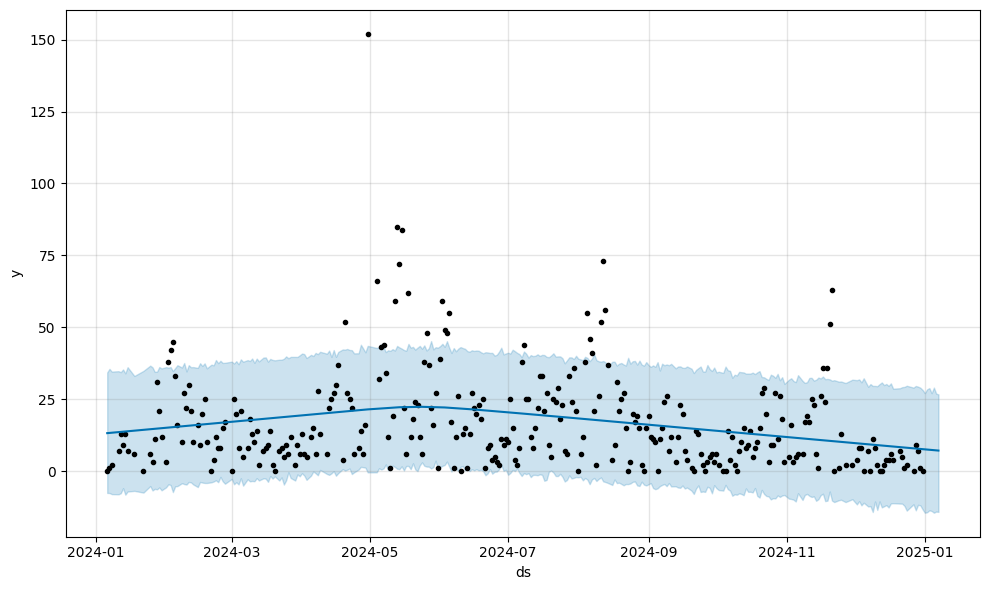

In [155]:
from prophet import Prophet

df_prophet = df_daily_sales.rename(columns={'date':'ds','ventas':'y'})
model = Prophet(
    weekly_seasonality=False,
    daily_seasonality=True
)
model.fit(df_prophet)

# Predecir los próximos 30 días
future = model.make_future_dataframe(periods=7, freq='D')
forecast = model.predict(future)

model.plot(forecast);

In [156]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          325 non-null    datetime64[ns]
 1   trend                       325 non-null    float64       
 2   yhat_lower                  325 non-null    float64       
 3   yhat_upper                  325 non-null    float64       
 4   trend_lower                 325 non-null    float64       
 5   trend_upper                 325 non-null    float64       
 6   additive_terms              325 non-null    float64       
 7   additive_terms_lower        325 non-null    float64       
 8   additive_terms_upper        325 non-null    float64       
 9   daily                       325 non-null    float64       
 10  daily_lower                 325 non-null    float64       
 11  daily_upper                 325 non-null    float64       

In [157]:
# forecast.sort_values('ds', ascending=True)
future_forecast = forecast[forecast['ds'] > df_daily_sales['date'].max()][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']]
future_forecast.head(10)

,ds,yhat,yhat_lower,yhat_upper,trend
318,2025-01-01,7.562166,-14.490843,27.101450,-2.999523
319,2025-01-02,7.491929,-14.307492,28.435284,-3.069761
320,2025-01-03,7.421691,-13.654168,28.857250,-3.139998
321,2025-01-04,7.351454,-13.857197,27.106307,-3.210236
322,2025-01-05,7.281216,-14.469770,29.040094,-3.280473
323,2025-01-06,7.210979,-14.075429,26.946428,-3.350711
324,2025-01-07,7.140741,-14.187736,26.669209,-3.420948


### Guardar modelo con pickle

In [158]:
import pickle
import os

models_dir = f'{base_path}/Models/'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

with open(f'{models_dir}/future_sales.pkl', 'wb') as f:
    pickle.dump(model, f)

## Creando un modelo para dectactar probabilidad de que un cliente va contractar si o no.

### Agregando dependencias

In [159]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### Cargando nuevamente dataset original

In [160]:
df_bank = pd.read_csv(f'{base_path}/Datasets/bank_marketing/bank/bank-full.csv', sep=';')
df = df_bank.drop(columns=['duration'])

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


#### Crear nuevas características


In [162]:
# Declarando variables objetivo
y = (df['y'] == 'yes').astype(int)
X = df.drop(columns=['y'])

In [163]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown


In [164]:
X['age_group'] = pd.cut(X['age'], bins=[0, 30, 50, 100], labels=['joven', 'adulto', 'mayor']).astype(str)
X['has_credit'] = (X['loan'] == 'yes').astype(int)
X['has_housing'] = (X['housing'] == 'yes').astype(int)
X['contact_digital'] = X['contact'].isin(['cellular', 'telephone']).astype(int)


#### Detectar columnas categóricas y numéricas

In [165]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]


In [166]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'age_group']

In [167]:
num_cols

['age',
 'balance',
 'day',
 'campaign',
 'pdays',
 'previous',
 'has_credit',
 'has_housing',
 'contact_digital']

In [168]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45211 non-null  int64 
 1   job              45211 non-null  object
 2   marital          45211 non-null  object
 3   education        45211 non-null  object
 4   default          45211 non-null  object
 5   balance          45211 non-null  int64 
 6   housing          45211 non-null  object
 7   loan             45211 non-null  object
 8   contact          45211 non-null  object
 9   day              45211 non-null  int64 
 10  month            45211 non-null  object
 11  campaign         45211 non-null  int64 
 12  pdays            45211 non-null  int64 
 13  previous         45211 non-null  int64 
 14  poutcome         45211 non-null  object
 15  age_group        45211 non-null  object
 16  has_credit       45211 non-null  int64 
 17  has_housing      45211 non-null

In [169]:
# Dividiendo los datos train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [170]:
# Variante — Escalado estándar + One-Hot
num_transformer_std = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer_oh = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor_std = ColumnTransformer([
    ('num', num_transformer_std, num_cols),
    ('cat', cat_transformer_oh, cat_cols)
])

In [171]:
# Variante — Escalado MinMax + OrdinalEncoder
num_transformer_minmax = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
cat_transformer_ord = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])
preprocessor_minmax = ColumnTransformer([
    ('num', num_transformer_minmax, num_cols),
    ('cat', cat_transformer_ord, cat_cols)
])


In [172]:
# Definiendo modelos a probar
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Boosted Decision Tree": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}


#### Probando diferentes combinaciones usando GridSearch

In [173]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import pandas as pd

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_auc = 0
best_model_name = None
best_prep_name = None
best_pipe = None

# Entrenamiento y evaluación combinada
for prep_name, preprocessor in [
    ("StandardScaler + OneHot", preprocessor_std),
    # ("MinMaxScaler + Ordinal", preprocessor_minmax)
]:
    for model_name, model in models.items():
        print(f"\nEntrenando combinación: {prep_name} | {model_name}")

        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Validación cruzada
        auc_cv = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

        # Entrenamiento final
        pipe.fit(X_train, y_train)

        # Evaluación
        y_pred_proba = pipe.predict_proba(X_test)[:, 1]
        auc_test = roc_auc_score(y_test, y_pred_proba)
        cm = confusion_matrix(y_test, (y_pred_proba >= 0.5).astype(int))

        print(f"AUC Test: {auc_test:.4f} (CV: {auc_cv:.4f})")

        # Guardar mejor modelo
        if auc_test > best_auc:
            print(f"** Nuevo mejor modelo guardado: {model_name} con {prep_name}")
            best_auc = auc_test
            best_model_name = model_name
            best_prep_name = prep_name
            best_pipe = pipe

        results.append({
            "Preprocesamiento": prep_name,
            "Modelo": model_name,
            "AUC_CV": auc_cv,
            "AUC_Test": auc_test,
            "Matriz Confusión": cm
        })

# Convertir a DataFrame para exportar
results_df = pd.DataFrame(results).sort_values(by="AUC_Test", ascending=False)
display(results_df[["Preprocesamiento", "Modelo", "AUC_CV", "AUC_Test"]])

# Validación final del mejor modelo
print("\n=== Mejor Modelo Final ===")
print(f"Modelo: {best_model_name}")
print(f"Preprocesamiento: {best_prep_name}")
print(f"AUC Test: {best_auc:.4f}")

encoder_type = type(best_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']).__name__
print(f"Encoder utilizado: {encoder_type}")
print(f"n_features_in_ del clasificador: {best_pipe.named_steps['classifier'].n_features_in_}")

# Guardar pipeline completo (con preprocesador y modelo)
with open(f"{models_dir}/best_pipeline.pkl", "wb") as f:
    pickle.dump(best_pipe, f)

print("\nPipeline completo guardado correctamente con preprocesamiento incluido.")


Entrenando combinación: StandardScaler + OneHot | Logistic Regression
AUC Test: 0.7704 (CV: 0.7649)
** Nuevo mejor modelo guardado: Logistic Regression con StandardScaler + OneHot

Entrenando combinación: StandardScaler + OneHot | Random Forest
AUC Test: 0.7814 (CV: 0.7730)
** Nuevo mejor modelo guardado: Random Forest con StandardScaler + OneHot

Entrenando combinación: StandardScaler + OneHot | Boosted Decision Tree
AUC Test: 0.7950 (CV: 0.7920)
** Nuevo mejor modelo guardado: Boosted Decision Tree con StandardScaler + OneHot


,Preprocesamiento,Modelo,AUC_CV,AUC_Test
2,StandardScaler + OneHot,Boosted Decision Tree,0.791994,0.794994
1,StandardScaler + OneHot,Random Forest,0.773043,0.781397
0,StandardScaler + OneHot,Logistic Regression,0.764862,0.770375



=== Mejor Modelo Final ===
Modelo: Boosted Decision Tree
Preprocesamiento: StandardScaler + OneHot
AUC Test: 0.7950
Encoder utilizado: OneHotEncoder
n_features_in_ del clasificador: 56

Pipeline completo guardado correctamente con preprocesamiento incluido.


In [174]:
best_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'campaign', 'pdays',
                                                   'previous', 'has_credit',
                                                   'has_housing',
                                                   'contact_digital']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'age_group'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

#### Probando modelo de prediccion con un cliente

In [175]:
data = dict({
    "age": 35,
    "job": "management",
    "marital": "married",
    "education": "tertiary",
    "default": "no",
    "balance": 3500,
    "housing": "yes",
    "loan": "no",
    "contact": "cellular",
    "day": 15,
    "month": "may",
    "campaign": 1,
    "pdays": -1,
    "previous": 0,
    "poutcome": "unknown"
})

df_test = pd.DataFrame.from_dict(data, orient='index').T
# Add back the feature engineering steps that are expected by the pipeline's preprocessor
df_test['age_group'] = pd.cut(df_test['age'].astype(int), bins=[0, 30, 50, 100], labels=['joven', 'adulto', 'mayor']).astype(str)
df_test['has_credit'] = (df_test['loan'] == 'yes').astype(int)
df_test['has_housing'] = (df_test['housing'] == 'yes').astype(int)
df_test['contact_digital'] = df_test['contact'].isin(['cellular', 'telephone']).astype(int)

display(df_test)

result_test = best_pipe.predict_proba(df_test) # Pass the raw data to the pipeline

result_test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,age_group,has_credit,has_housing,contact_digital
0,35,management,married,tertiary,no,3500,yes,no,cellular,15,may,1,-1,0,unknown,adulto,0,1,1


array([[0.89145193, 0.10854807]])

#### Validando y guardando resultados

In [176]:

results_df = pd.DataFrame(results).sort_values(by="AUC_Test", ascending=False)
print(results_df[['Preprocesamiento', 'Modelo', 'AUC_CV', 'AUC_Test']])

          Preprocesamiento                 Modelo    AUC_CV  AUC_Test
2  StandardScaler + OneHot  Boosted Decision Tree  0.791994  0.794994
1  StandardScaler + OneHot          Random Forest  0.773043  0.781397
0  StandardScaler + OneHot    Logistic Regression  0.764862  0.770375


In [177]:
results_df.to_csv(f'{base_path}/model_comparison_results.csv', index=False)

### Almancenado mejor Pipeline

## Identificar grupos/clusters para identificar oportunidades

#### Creando dataframe con columnas requeridas

In [178]:
df_bank_clusters = X[['age_group', 'job', 'marital', 'education', 'balance', 'has_housing', 'has_credit', 'contact_digital',  'campaign', 'pdays', 'previous']].copy()
df_bank_clusters['age_group'] = df_bank_clusters['age_group'].astype('object')
df_bank_clusters['y'] = y.copy()

In [179]:
df_bank_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age_group        45211 non-null  object
 1   job              45211 non-null  object
 2   marital          45211 non-null  object
 3   education        45211 non-null  object
 4   balance          45211 non-null  int64 
 5   has_housing      45211 non-null  int64 
 6   has_credit       45211 non-null  int64 
 7   contact_digital  45211 non-null  int64 
 8   campaign         45211 non-null  int64 
 9   pdays            45211 non-null  int64 
 10  previous         45211 non-null  int64 
 11  y                45211 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.1+ MB


#### Generando clusters

In [180]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Detectar columnas categóricas y numéricas
cat_cols = df_bank_clusters.select_dtypes(include='object').columns
num_cols = df_bank_clusters.select_dtypes(exclude='object').columns

# Transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar en un solo preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Pipeline completo con KMeans
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=10, random_state=42))
])

# Entrenar el pipeline (sin y)
pipe.fit(df_bank_clusters)

# Obtener los clusters
labels = pipe.named_steps['cluster'].labels_
X_clustered = df_bank_clusters.copy()
X_clustered['cluster'] = labels

#### Guardando dataset con clasters clusters

In [181]:
X_clustered.to_csv(f'{base_path}/bank_full_with_clusters.csv', index=False)

#### Explorando resultados.

In [182]:
X_clustered[X_clustered['cluster'] == 3]

,age_group,job,marital,education,balance,has_housing,has_credit,contact_digital,campaign,pdays,previous,y,cluster
24136,adulto,management,married,tertiary,1770,1,0,0,1,101,11,0,3
24295,adulto,technician,divorced,tertiary,1718,1,1,1,1,167,16,0,3
24331,adulto,management,married,tertiary,5057,1,0,1,1,166,10,0,3
24506,adulto,unemployed,married,unknown,970,1,0,1,1,119,10,0,3
24556,adulto,management,married,tertiary,1451,1,0,1,3,150,12,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45165,adulto,technician,married,tertiary,2976,1,0,1,2,95,12,0,3
45171,adulto,admin.,single,secondary,690,0,0,1,3,555,16,0,3
45172,joven,technician,single,tertiary,2325,0,0,1,1,92,8,0,3
45199,adulto,blue-collar,single,secondary,1475,1,0,1,3,530,12,0,3


#### Identificando posibilidad de contratacion por cada clusters



In [183]:
df_clusters =  X_clustered.groupby('cluster')['y'].value_counts(normalize=True).sort_values(ascending=False)

In [184]:
df_clusters.to_csv(f'{base_path}/bank_full_clusters.csv', index=False)
df_clusters

,,proportion
cluster,y,
0,0,1.000000
1,1,1.000000
4,0,1.000000
8,0,1.000000
6,0,1.000000
5,0,0.999698
2,0,0.997412
9,0,0.933365
7,0,0.901832
